# Solving the Malthus model

> **Table of contents:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

*Imports and set magics*

In [11]:
import numpy as np
from scipy import optimize
import sympy as sm
from types import SimpleNamespace

# plotting
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject as mp

import ipywidgets as widgets # For interactive plots/buttons

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

**Write out the model in equations here.** 

Make sure you explain well the purpose of the model and comment so that other students who may not have seen it before can follow.  

We consider the **standard Malthus-model**. We assume discrete time, $t\in\{0,1,\dots\}$ and a closed economy. Therefore, total production equals income. 

An assumption in the Malthus model is that labor is subject to diminishing returns in production. We model this with a **Cobb-Douglas production function**:

$$
Y_{t}=L_{t}^{1-\alpha}(AX)^{\alpha}
$$

Where: 
1. $L_t$ is labor (we assume no unemployment)
3. $A$ is technology (is constant over time)
4. $X$ is land (is constant over time)
5. $Y_t$ = is GDP (production). This is equal to income.

**Output pr. worker** is thus given by:

$$
y_{t}=\left(\frac{AX}{L_t}\right)^{\alpha}
$$

Since $\alpha<1$ (diminishing returns) we have that as L increases, output per worker declines, given that AX is constant.

**Household preferences** are given by:

$$
u_{t} = \beta \log (c_{t}) + (1-\beta) \log (n_{t}), \ \ \ 0<\beta<1
$$

Where: 
1. $c_t$ is consumption
3. $n_t$ is the number of children

And the **budget constraint** is given by:

$$
y_{t} ≥ \lambda n_{t} + c_{t}
$$

The size of the labor force evolves according to:

$$
L_{t+1} = n_{t}L_{t}+(1-\mu)L_{t}, \ \ \ L_{0} \ given
$$

The above equation implies that $\mu$ represents mortality.

The **law of motion for the labor force** will therefore be given by:

$$
L_{t+1} = \eta L_{t}^{1-\alpha}(AX)^{\alpha}+(1-\mu)L_{t}, \ \ \ L_{0} \ given
$$

Where $\eta=\frac{1-\beta}{\lambda}$

## Analytical solution

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

In [12]:
Yt = sm.symbols('Y_t')
Lt = sm.symbols('L_t')
Lt1 = sm.symbols('L_{t+1}')
A = sm.symbols('A')
X = sm.symbols('X')
yt = sm.symbols('y_t')
nt = sm.symbols('n_t')
alpha = sm.symbols('alpha')
mu = sm.symbols('mu')
eta = sm.symbols('eta')
L_star = sm.symbols('L^*')
y_star = sm.symbols('y^*')
beta = sm.symbols('beta')
ct = sm.symbols('c_t')
ut = sm.symbols('u_t')
lamb = sm.symbols('lambda')

The household preferences are given by:

In [13]:
utility = beta*sm.log(ct)+(1-beta)*sm.log(nt)
utility

beta*log(c_t) + (1 - beta)*log(n_t)

We assume that household's use all their available income for either consumption or child rearing:

In [14]:
budget = sm.Eq(yt, lamb*nt+ct)
budget

Eq(y_t, c_t + lambda*n_t)

We solve this by isolating consumption in the budget constraint and then substituting this expression into the utility function. We then optimize over number of children:

In [15]:
# isolate consumption
ct_from_budget = sm.solve(budget, ct)

# substitute into the budget constraint
utility_subs = utility.subs(ct, ct_from_budget[0])

# take the derivattive w.r.t. number of children
foc = sm.diff(utility_subs, nt)

# solving the FOC for optimal number of children
sol = sm.solve(sm.Eq(foc,0), nt)[0]
sol

y_t*(1 - beta)/lambda

The above expression determines the optimal number of children for the household.

Below we find the steady state level for the labor force given the law of motion:

In [16]:
# Law of motion
LOM = sm.Eq(Lt1, eta*Lt**(1-alpha)*(A*X)**alpha+(1-mu)*Lt)
LOM

Eq(L_{t+1}, L_t*(1 - mu) + L_t**(1 - alpha)*eta*(A*X)**alpha)

To find the steady state value for the labor force we substitute, such that $L^* = L_{t} = L_{t+1}$ and solve for $L^*$:

In [17]:
# Substitute for L*
SS = sm.Eq(L_star, eta*L_star**(1-alpha)*(A*X)**alpha+(1-mu)*L_star)

# Solve for L_star
L_star_sol = sm.solve(SS, L_star)[0]

# Print the solution
L_star_sol

(eta*(A*X)**alpha/mu)**(1/alpha)

We can turn the expression for steady state labor force into a Python-function to evaluate the solution:

In [18]:
ss_L_func = sm.lambdify((A,X,eta,mu,alpha),L_star_sol)
ss_L_func(1,2,0.8,0.2,0.33)

133.49168402513862

## Numerical solution

You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

**Approach using code from the py-file:**

In [19]:
model = mp.MalthusModelClass()
par = model.par
ss = model.ss
path = model.path

initializing the model:
calling .setup()
calling .allocate()


In [21]:
model.solve()

AttributeError: 'types.SimpleNamespace' object has no attribute 'L_lag_ini'

**Trying to find SS and plotting convergence:**

In [22]:
par =  SimpleNamespace()
par.eta = 0.2
par.mu = 0.3
par.alpha = 0.6
par.A = 1
par.X = 3

obj_lss = lambda lss: lss - (par.eta*lss**(1-par.alpha)*(par.A*par.X)**(par.alpha)+(1-par.mu)*lss)
result = optimize.root_scalar(obj_lss,bracket=[0.1,1000],method='brentq')

print('The steady state for L is',result.root)

The steady state for L is 1.5262856567377756


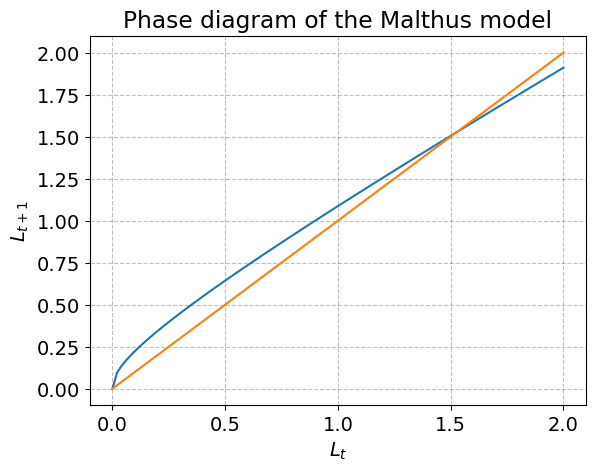

In [23]:
# Number of observations 
N = 100

# Max value of L_t
L_max = 2

def create_plot(par,L_max,N):
    # Create a vector x1 from 0 to x_max, with N values
    L_vec = np.linspace(0,L_max,N)

    # Create an empty vector to store values of L_t+1
    L2_vec = np.empty(N)

    def L_func(lss,par=par):
        return par.eta*lss**(1-par.alpha)*(par.A*par.X)**(par.alpha)+(1-par.mu)*lss

    # Fill out out the vector
    for i, lss in enumerate(L_vec):
        L2_vec[i] = L_func(lss)

    # Create an empty vector to store values of L_t+1
    L3_vec = np.empty(N)

    # Fill out out the vector
    for i, lss in enumerate(L_vec):
        L3_vec[i] = lss

    # a. create the figure
    fig = plt.figure()

    # b. plot
    ax = fig.add_subplot(1,1,1)
    ax.plot(L_vec,L2_vec);
    ax.plot(L_vec,L3_vec);

    ax.set_title('Phase diagram of the Malthus model')
    ax.set_xlabel('$L_{t}$')
    ax.set_ylabel('$L_{t+1}$');

create_plot(par,L_max,N)

**Trying to update using the law of motion**

In [26]:
par =  SimpleNamespace()
par.eta = 0.2
par.mu = 0.3
par.alpha = 0.6
par.A = 1
par.X = 2
par.T = 500
L_init = 0.1  # specify initial value of L

L_path = np.zeros(par.T)  # initialize a vector to store optimal L for each time period
L_path[0] = L_init  # set the initial value of L in the vector

for i in range(1,par.T):

    # a. find next period L
    L_next = par.eta*L_init**(1-par.alpha)*(par.A*par.X)**(par.alpha)+(1-par.mu)*L_init

    # b. store value
    L_path[i] = L_next

    # c. update
    L_init = L_next
    

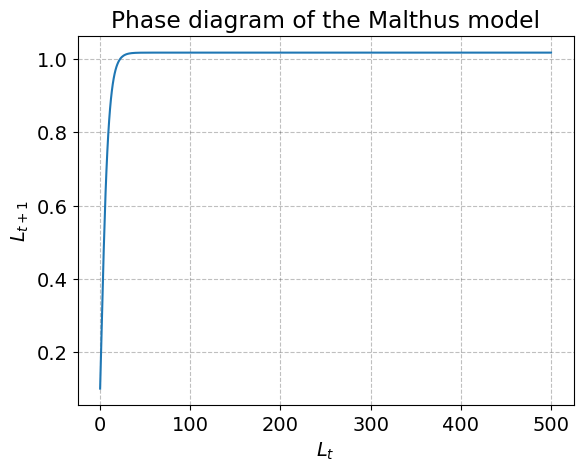

In [27]:
N=500
T_vec = np.linspace(0,par.T,N)
fig = plt.figure()

# b. plot
ax = fig.add_subplot(1,1,1)
ax.plot(T_vec,L_path)
ax.set_title('Phase diagram of the Malthus model')
ax.set_xlabel('$L_{t}$')
ax.set_ylabel('$L_{t+1}$');

# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

# Extension of the model

We can extend the model with technological growth. 
$$
\frac{A_{t+1}}{A_{t}} = g
$$

where g is this growth factor. In the baseline model $g=1$

We define $ l_{t} = \frac{L_{t}}{A_{t}} $

With technological change we get a slighty changed law of motion
$$
L_{t+1} = \eta L_{t}^{1-\alpha}(A_{t}X)^{\alpha}+(1-\mu)L_{t}, \ \ \ L_{0} \ given
$$


Analytical solution

In [ ]:
lt = sm.symbols('l_t')
g = sm.symbols('g')
At = sm.symbols('A_t')
At1 = sm.symbols('A_{t+1}')
l_star = sm.symbols('l^*')
Yt = sm.symbols('Y_t')
Lt = sm.symbols('L_t')
Lt1 = sm.symbols('L_{t+1}')
A = sm.symbols('A')
X = sm.symbols('X')
yt = sm.symbols('y_t')
nt = sm.symbols('n_t')
alpha = sm.symbols('alpha')
mu = sm.symbols('mu')
eta = sm.symbols('eta')
L_star = sm.symbols('L^*')
y_star = sm.symbols('y^*')

In [ ]:
# New law of motion
New_LOM = sm.Eq(Lt1, eta*Lt**(1-alpha)*(At*X)**alpha+(1-mu)*Lt)
New_LOM

Dividing the law of motion with $ A_{t} $

$$
\frac{L_{t+1}}{A_{t}} = \eta A_{t}^{-1} L_{t}^{1-\alpha}(A_{t}X)^{\alpha}+(1-\mu) \frac{L_{t}}{A_{t}}
$$

In [ ]:
# law of motion for l
New_LOM2 = sm.Eq((Lt1/At), eta*At**(-1)*Lt**(1-alpha)*(At*X)**alpha+(1-mu)*(Lt/At))
New_LOM2

Note that: 
$$
\frac{L_{t+1}}{A_{t}} = \frac{L_{t+1}}{A_{t+1}} \frac{A_{t+1}}{A_{t}} = l_{t+1}g
$$

Substituting this into the modified law of motion

$$
l_{t+1} = \eta g^{-1} l_{t}^{1-\alpha} X^{\alpha}+g^{-1}(1-\mu) l_{t}
$$

To find the steady state value for the labor force we substitute, such that $l^* = l_{t} = l_{t+1}$ and solve for $l^*$:

In [ ]:
# Substitute for l*
SS = sm.Eq(l_star, eta*g**(-1)*l_star**(1-alpha)*X**alpha+g**(-1)*(1-mu)*l_star)

# Solve for L_star
l_star_sol = sm.solve(SS, l_star)[0]

# Print the solution
l_star_sol

We can turn the expression for steady state labor force into a Python-function to evaluate the solution:

In [ ]:
ss_l_func = sm.lambdify((g,X,eta,mu,alpha),l_star_sol)
ss_l_func(1,1,0.3,0.5,0.5)

Numerical solution

In [ ]:
eta = 0.2
mu = 0.3
alpha = 1/3
g = 1
X = 2

obj_lss2 = lambda lss2: lss2 - (eta*g**(-1)*lss2**(1-alpha)*X**(alpha)+g**(-1)*(1-mu)*lss2)
result = optimize.root_scalar(obj_lss2,bracket=[0.1,1000],method='brentq')

print('The steady state for l is',result.root)  

# Conclusion

Add concise conclusion. 